Starting training...
Epoch 1/30, Loss: 2.4387, Accuracy: 0.0560
Epoch 2/30, Loss: 2.3815, Accuracy: 0.0660
Epoch 3/30, Loss: 2.3467, Accuracy: 0.1100
Epoch 4/30, Loss: 2.3476, Accuracy: 0.1200
Epoch 5/30, Loss: 2.3689, Accuracy: 0.0880
Epoch 6/30, Loss: 2.4486, Accuracy: 0.1000
Epoch 7/30, Loss: 2.3585, Accuracy: 0.0720
Epoch 8/30, Loss: 2.4140, Accuracy: 0.0340
Epoch 9/30, Loss: 2.3151, Accuracy: 0.0740
Epoch 10/30, Loss: 2.4414, Accuracy: 0.0840
Epoch 11/30, Loss: 2.3424, Accuracy: 0.1020
Epoch 12/30, Loss: 2.4223, Accuracy: 0.1400
Epoch 13/30, Loss: 2.3852, Accuracy: 0.0660
Epoch 14/30, Loss: 2.3121, Accuracy: 0.1040
Epoch 15/30, Loss: 2.2923, Accuracy: 0.1560
Epoch 16/30, Loss: 2.4217, Accuracy: 0.0680
Epoch 17/30, Loss: 2.4362, Accuracy: 0.0620
Epoch 18/30, Loss: 2.3672, Accuracy: 0.1140
Epoch 19/30, Loss: 2.3720, Accuracy: 0.0920
Epoch 20/30, Loss: 2.4151, Accuracy: 0.0900
Epoch 21/30, Loss: 2.4650, Accuracy: 0.0560
Epoch 22/30, Loss: 2.4915, Accuracy: 0.0760
Epoch 23/30, Loss: 2

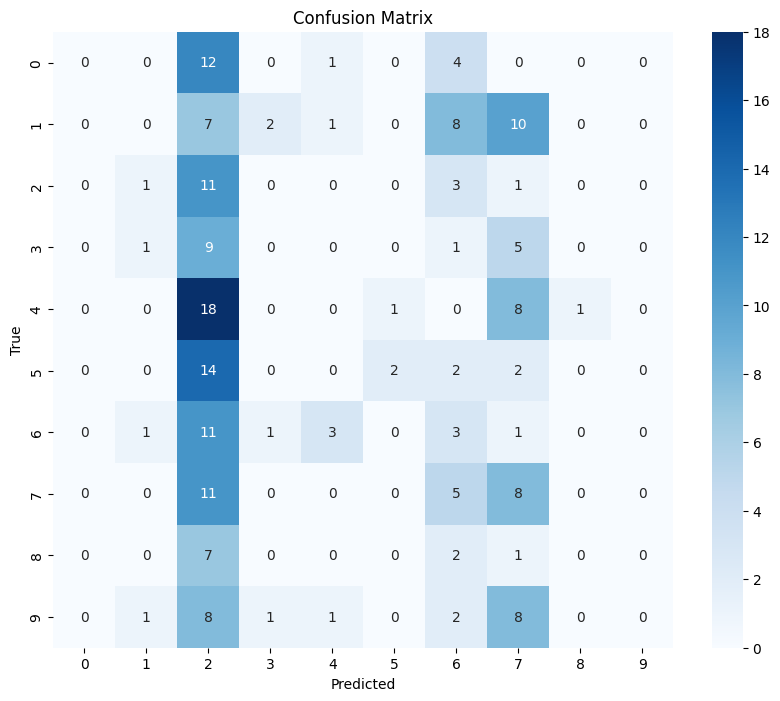

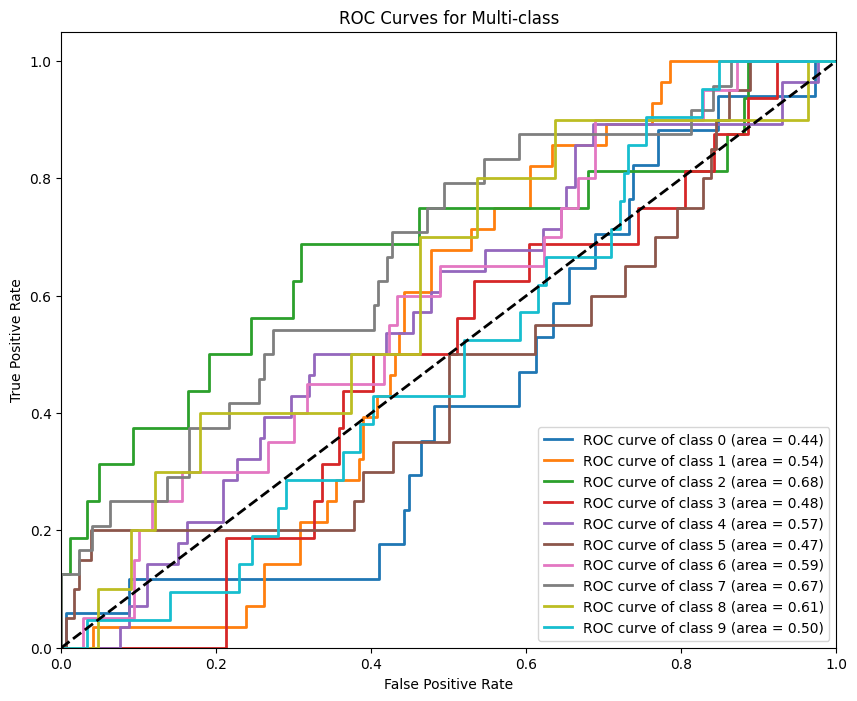


=== Classification Report ===
Class 0:
  TP: 0, FP: 0, FN: 17, TN: 183
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Class 1:
  TP: 0, FP: 4, FN: 28, TN: 168
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Class 2:
  TP: 11, FP: 97, FN: 5, TN: 87
  Precision: 0.1019, Recall: 0.6875, F1: 0.1774
Class 3:
  TP: 0, FP: 4, FN: 16, TN: 180
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Class 4:
  TP: 0, FP: 6, FN: 28, TN: 166
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Class 5:
  TP: 2, FP: 1, FN: 18, TN: 179
  Precision: 0.6667, Recall: 0.1000, F1: 0.1739
Class 6:
  TP: 3, FP: 27, FN: 17, TN: 153
  Precision: 0.1000, Recall: 0.1500, F1: 0.1200
Class 7:
  TP: 8, FP: 36, FN: 16, TN: 140
  Precision: 0.1818, Recall: 0.3333, F1: 0.2353
Class 8:
  TP: 0, FP: 1, FN: 10, TN: 189
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Class 9:
  TP: 0, FP: 0, FN: 21, TN: 179
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Overall metrics:
  Accuracy: 0.1200
  Average Precision: 0.1050
  Average Re

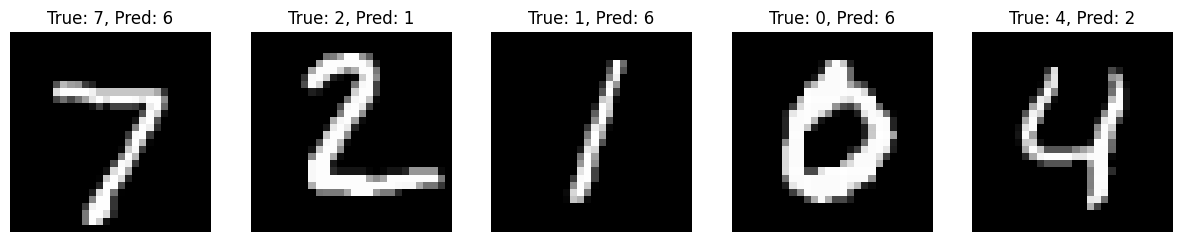


=== Experimenting with different configurations ===
Config 1 (LeakyReLU + Sigmoid): Accuracy = 0.1450
Config 2 (Deeper network with more neurons): Accuracy = 0.0700
Config 3 (Single hidden layer with tanh): Accuracy = 0.1600


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import struct
import pandas as pd
from sklearn.metrics import roc_curve, auc

# === Step 1: Load MNIST Dataset ===
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows * cols)
    return images / 255.0

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# Load datasets (adjust file paths if needed)
X_train = load_mnist_images("train-images.idx3-ubyte___")[:500]
y_train = load_mnist_labels("train-labels.idx1-ubyte___")[:500]
X_test = load_mnist_images("t10k-images.idx3-ubyte___")[:200]
y_test = load_mnist_labels("t10k-labels.idx1-ubyte___")[:200]

# === Step 2: Activation Functions (Refer to Eq. 6.14 - 6.18) ===
def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

def softplus(x):
    return np.log(1 + np.exp(x))

def leaky_relu(x, alpha=0.1):
    return np.where(x > 0, x, alpha * x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def one_hot(y, num_classes=10):  # Refer to Equation 6.36
    one_hot_matrix = np.zeros((len(y), num_classes))
    for i, label in enumerate(y):
        one_hot_matrix[i, label] = 1
    return one_hot_matrix

def softmax(a):  # Refer to Equation 6.37
    # Subtracting max(a) for numerical stability
    exp_a = np.exp(a - np.max(a, axis=1, keepdims=True))
    return exp_a / np.sum(exp_a, axis=1, keepdims=True)

def cross_entropy(y_pred, y_true):  # Refer to Equation 6.36
    # Small epsilon to avoid log(0)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred)) / len(y_true)

def forward_pass(X, weights, activations):  # Forward Pass (Eq. 6.19)
    layer_outputs = [X]
    layer_inputs = []
    
    for i in range(len(weights)):
        # Calculate the input to this layer (z^(l) = W^(l) * a^(l-1))
        layer_input = np.dot(layer_outputs[-1], weights[i])
        layer_inputs.append(layer_input)
        
        # Apply activation function h^(l)(z^(l))
        layer_output = activations[i](layer_input)
        layer_outputs.append(layer_output)
    
    return layer_outputs[-1], layer_outputs, layer_inputs

# === Step 3: Initialize the Model and Training Loop ===
def initialize_weights(input_size, hidden_sizes, output_size):
    sizes = [input_size] + hidden_sizes + [output_size]
    weights = []
    
    for i in range(len(sizes) - 1):
        # Xavier/Glorot initialization for better convergence
        scale = np.sqrt(2.0 / (sizes[i] + sizes[i+1]))
        weights.append(np.random.normal(scale=scale, size=(sizes[i], sizes[i+1])))
    
    return weights

def evaluate_model(X, y, weights, activations):
    predictions, _, _ = forward_pass(X, weights, activations)
    y_true_oh = one_hot(y)
    loss = cross_entropy(predictions, y_true_oh)
    
    # Convert softmax probabilities to class predictions
    y_pred = np.argmax(predictions, axis=1)
    accuracy = np.mean(y_pred == y)
    
    return loss, accuracy, predictions, y_pred, y_true_oh

# === Step 4: Evaluation Metrics ===
def compute_confusion_matrix(y_true, y_pred, num_classes=10):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    return cm

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def compute_roc(y_true_oh, y_pred_proba):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_true_oh.shape[1]
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_oh[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    return fpr, tpr, roc_auc

def plot_roc_curves(fpr, tpr, roc_auc):
    plt.figure(figsize=(10, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for i, color in zip(range(10), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multi-class')
    plt.legend(loc="lower right")
    plt.show()

def compute_metrics(cm):
    n_classes = cm.shape[0]
    precision = np.zeros(n_classes)
    recall = np.zeros(n_classes)
    f1 = np.zeros(n_classes)
    
    for i in range(n_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        tn = np.sum(cm) - tp - fp - fn
        
        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0
        
        print(f"Class {i}:")
        print(f"  TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")
        print(f"  Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}")
    
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_f1 = np.mean(f1)
    
    print("\nOverall metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Average Precision: {avg_precision:.4f}")
    print(f"  Average Recall: {avg_recall:.4f}")
    print(f"  Average F1: {avg_f1:.4f}")
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_f1': avg_f1
    }

# Main execution
if __name__ == "__main__":
    # Model configuration - Can be modified for experimentation
    input_size = 784  # 28x28 images
    hidden_sizes = [128, 64]  # Two hidden layers
    output_size = 10  # 10 digits
    activations = [relu, tanh, softmax]  # Activation functions for each layer
    
    np.random.seed(42)
    epochs = 30
    best_loss = float('inf')
    best_weights = None
    best_accuracy = 0
    
    # Training loop
    print("Starting training...")
    for epoch in range(epochs):
        # Initialize weights for each epoch (as per the assignment requirement)
        weights = initialize_weights(input_size, hidden_sizes, output_size)
        
        # Forward pass and evaluation
        train_loss, train_accuracy, _, _, _ = evaluate_model(X_train, y_train, weights, activations)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
        
        # Save best model
        if train_accuracy > best_accuracy:
            best_accuracy = train_accuracy
            best_loss = train_loss
            best_weights = weights.copy()
    
    print(f"\nTraining completed. Best Loss: {best_loss:.4f}, Best Accuracy: {best_accuracy:.4f}")
    
    # Evaluation on test set
    test_loss, test_accuracy, test_predictions, test_pred_classes, test_true_oh = evaluate_model(
        X_test, y_test, best_weights, activations
    )
    
    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # Compute confusion matrix
    cm = compute_confusion_matrix(y_test, test_pred_classes)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plot_confusion_matrix(cm, classes=range(10))
    
    # Compute and plot ROC curves
    fpr, tpr, roc_auc = compute_roc(test_true_oh, test_predictions)
    plot_roc_curves(fpr, tpr, roc_auc)
    
    # Compute classification metrics
    print("\n=== Classification Report ===")
    metrics = compute_metrics(cm)
    
    # Example: Visualize a few test images with predictions
    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_test[i]}, Pred: {test_pred_classes[i]}")
        plt.axis('off')
    plt.show()

    # Experiment with different activation functions and network structures
    print("\n=== Experimenting with different configurations ===")
    
    # Configuration 1: Different activation functions
    activations1 = [leaky_relu, sigmoid, softmax]
    weights1 = initialize_weights(input_size, hidden_sizes, output_size)
    _, accuracy1, _, _, _ = evaluate_model(X_test, y_test, weights1, activations1)
    print(f"Config 1 (LeakyReLU + Sigmoid): Accuracy = {accuracy1:.4f}")
    
    # Configuration 2: Different layer sizes
    hidden_sizes2 = [256, 128, 64]
    activations2 = [relu, relu, relu, softmax]
    weights2 = initialize_weights(input_size, hidden_sizes2, output_size)
    _, accuracy2, _, _, _ = evaluate_model(X_test, y_test, weights2, activations2)
    print(f"Config 2 (Deeper network with more neurons): Accuracy = {accuracy2:.4f}")
    
    # Configuration 3: Single hidden layer
    hidden_sizes3 = [100]
    activations3 = [tanh, softmax]
    weights3 = initialize_weights(input_size, hidden_sizes3, output_size)
    _, accuracy3, _, _, _ = evaluate_model(X_test, y_test, weights3, activations3)
    print(f"Config 3 (Single hidden layer with tanh): Accuracy = {accuracy3:.4f}")
    